In [8]:
import pandas as pd
import numpy as np
import re
# from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")


In [9]:
df = pd.read_excel("data/cleaning.xlsx")

In [10]:
# compute number of day elapsed between calls
df = df.sort_values(by=["match_id", "completion_date"])
df['ndays_between_call'] = df.groupby("match_id")["completion_date"].diff().dt.days

df.fillna(0, inplace=True)

In [11]:
gap_stats = df.groupby('match_id')['ndays_between_call'].agg(['mean', 'max', 'std', 'count']).reset_index()
gap_stats.rename(
    columns={
        "mean": "avg_cadence_day",
        "max": "max_cadence_day",
        "count": "call_count"
    }
    ,inplace=True
)
gap_stats = gap_stats.fillna(0)
gap_stats


,match_id,avg_cadence_day,max_cadence_day,std,call_count
0,a1v2J0000027CXKQA2,15.000000,30.0,21.213203,2
1,a1v2J0000027JFCQA2,76.363636,156.0,48.380312,11
2,a1v2J0000027KBoQAM,37.000000,82.0,24.951381,8
3,a1v2J0000027KCEQA2,35.400000,61.0,24.449949,5
4,a1v2J0000027KCbQAM,43.857143,90.0,27.853357,7
...,...,...,...,...,...
295,a1vHt000005BXMnIAO,24.500000,49.0,34.648232,2
296,a1vUX0000009FvtYAE,23.600000,36.0,14.536162,5
297,a1vUX000000DcnRYAS,19.750000,38.0,17.366155,4
298,a1vUX000000U9QrYAK,24.500000,35.0,16.663333,4


In [12]:
df = pd.merge(df, gap_stats, on="match_id", how="left")


In [13]:

# Function to split early and late stage call notes
def split_call_notes(match_df):
    num_calls = len(match_df)
    
    # Edge case: no calls or only one call
    if num_calls == 0:
        return pd.Series(["unavailable", "unavailable"], index=["early_stage_notes", "late_stage_notes"])
    
    elif num_calls == 1:
        return pd.Series([match_df["contact_notes"].iloc[0], "unavailable"],index=["early_stage_notes", "late_stage_notes"])
    
    # Split the match calls into early and late stages based on call count
    early_stage = match_df.head(num_calls // 2)["contact_notes"].str.cat(sep=" ")  # First 50% of the calls
    late_stage = match_df.tail(num_calls - (num_calls // 2))["contact_notes"].str.cat(sep=" ")  # Remaining calls
    
    return pd.Series([early_stage, late_stage], index=["early_stage_notes", "late_stage_notes"])

# Apply the function for each match and concatenate
df_grouped = df.groupby("match_id").apply(split_call_notes).reset_index()

# Merge back with the original dataframe
df_final = pd.merge(df, df_grouped, on="match_id", how="left")


In [14]:
# dropped used columns
data = df_final.drop(['completion_date', 'contact_notes', "ndays_between_call"], axis=1).groupby("match_id").first().reset_index()

In [15]:
# Text Preprocessing Function
def preprocess(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    return text

In [16]:
data['early_stage_notes'] = data['early_stage_notes'].apply(preprocess)
data['late_stage_notes'] = data['late_stage_notes'].apply(preprocess)

# Convert texts into TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(data['early_stage_notes'].tolist() + data['late_stage_notes'].tolist())

# Split into early and late vectors
num_matches = len(data)
early_tfidf = tfidf_matrix[:num_matches]
late_tfidf = tfidf_matrix[num_matches:]

# Compute Cosine Similarity between early and late notes
similarity_scores = [cosine_similarity(early_tfidf[i], late_tfidf[i])[0, 0] for i in range(num_matches)]

# Add topic consistency scores to DataFrame
data['topic_consistency'] = similarity_scores

In [17]:
data['topic_consistency']

0      0.589216
1      0.660283
2      0.631338
3      0.521566
4      0.599792
         ...   
295    0.171631
296    0.532257
297    0.732802
298    0.687605
299    0.141151
Name: topic_consistency, Length: 300, dtype: float64

In [19]:
# Download VADER Lexicon (if not already downloaded)
nltk.download("vader_lexicon")

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/amen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [20]:
### **5️⃣ Assign Broad Match Categories**
keywords = {
    "shared_interest": [
        "love", "like", "enjoy", "passion", "hobby", "interest", "games",
        "sports", "music", "movies", "books", "reading", "art", "drawing",
        "painting", "writing", "creative", "dancing", "theater", "acting",
        "outdoors", "hiking", "camping", "travel", "adventure", "photography",
        "fitness", "exercise", "gym", "technology", "coding", "anime", "gaming",
        "board games", "strategy games", "puzzle", "cooking", "baking"
    ],
    
    "career": [
        "career", "job", "work", "goal", "future", "internship", "education",
        "college", "university", "study", "skills", "learning", "profession",
        "aspiration", "training", "employment", "resume", "interview", "networking",
        "mentorship", "scholarship", "certification", "growth", "promotion",
        "company", "business", "entrepreneur", "freelance", "industry", "field",
        "research", "technology", "engineering", "medical", "law", "finance",
        "science", "teaching", "management", "leadership", "trade", "construction",
        "coding", "startup", "job market", "salary", "income"
    ],
    
    "location": [
        "neighborhood", "city", "state", "close", "near", "distance",
        "same area", "nearby", "local", "region", "town", "village", "suburb",
        "downtown", "urban", "rural", "relocate", "move", "transportation",
        "commute", "drive", "bus", "train", "subway", "car", "bike", "walking",
        "travel time", "home", "apartment", "house", "living situation"
    ],
    
    "family": [
        "single parent", "siblings", "family", "home", "mom", "dad", "guardian",
        "grandparents", "cousins", "aunt", "uncle", "foster", "adoption",
        "step-parent", "step-sibling", "relative", "household", "parents",
        "childhood", "raising", "support system", "home life", "kids", "parenting",
        "family values", "responsibility", "brother", "sister", "niece", "nephew"
    ],
    
    "volunteering": [
        "volunteer", "help", "community", "leadership", "giving back",
        "nonprofit", "charity", "service", "mentor", "tutor", "teaching",
        "fundraising", "social work", "outreach", "activism", "advocacy",
        "awareness", "support", "public service", "coaching", "guidance",
        "mentorship", "helping others", "environmental work", "animal shelter",
        "soup kitchen", "homeless", "donation", "relief work", "medical aid",
        "youth program", "elderly care", "social good", "positive impact",
        "teamwork", "organizing", "initiatives", "volunteer work"
    ]
}


def categorize_match(text):
    text = text.lower()
    categories = {key: any(word in text for word in words) for key, words in keywords.items()}
    return categories

df_categories = data["rationale_for_match"].apply(categorize_match).apply(pd.Series)
data = pd.concat([data, df_categories], axis=1)

In [21]:
data

,match_id,big_age,big_occupation,big_gender,program,program_type,big_race_ethnicity,rationale_for_match,little_gender,little_participant__race_ethnicity,...,std,call_count,early_stage_notes,late_stage_notes,topic_consistency,shared_interest,career,location,family,volunteering
0,a1v2J0000027CXKQA2,25,Student: High School,Male,YIP 2016,Site,Asian;,Both are male and Hmong. They share similar in...,Male,Asian,...,21.213203,2,question activities answer bb and lb have been...,question activities answer bb and lb have been...,0.589216,True,False,False,False,False
1,a1v2J0000027JFCQA2,38,Tech: Engineer,Male,General Community,Community,White or Caucasian;,L_first_name and B_first_name were matched bec...,Male,Black or African American,...,48.380312,11,question activities answer mec met with bb at ...,october email check in form 2019 how many time...,0.660283,True,False,True,False,False
2,a1v2J0000027KBoQAM,37,Customer Service,Male,BSW-General Mills,Site Based Facilitated,White or Caucasian;,L_first_name was really wanting to be rematche...,Male,Black or African American,...,24.951381,8,question activities answer mc introduced bb an...,question activities answer b_first_name is int...,0.631338,False,False,False,False,False
3,a1v2J0000027KCEQA2,24,Student: High School,Female,School-Based Program,Site,Asian;,"BS is a leader, positive, experienced, and smi...",Female,Asian,...,24.449949,5,question activities answer bs has only met wit...,question activities answer bs said they have b...,0.521566,False,False,False,False,False
4,a1v2J0000027KCbQAM,31,Business,Male,School-Based Program,Site,White or Caucasian;,Conor was open to who he worked with and I tho...,Male,Black or African American,...,27.853357,7,question activities answer mc asked bb how his...,question activities answer this support contac...,0.599792,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,a1vHt000005BXMnIAO,47,"Business: Mgt, Admin",Female,BSW-Cargill,Site Based Facilitated,White or Caucasian;,B_first_name and L_first_name share the intere...,Female,Black or African American,...,34.648232,2,pc asked b_first_name how many times she has m...,this ms is based on b_first_name s sb survey p...,0.171631,True,True,False,False,False
296,a1vUX0000009FvtYAE,23,Student: College,Female,St Thomas/Four Seasons,Site,White or Caucasian;,B_first_name and L_first_name both appreciate ...,Male,Other,...,14.536162,5,pc sent an email to bs to complete match suppo...,pc contacted bs via email to complete match su...,0.532257,True,False,True,False,False
297,a1vUX000000DcnRYAS,47,Education,Female,General Community,Community,White or Caucasian;,1. Distance: 10 miles (14 mins) 2. Shared Trai...,Female,Black or African American,...,17.366155,4,bs was out of town before spring break ls ende...,email email_address your name first and last b...,0.732802,True,False,True,False,False
298,a1vUX000000U9QrYAK,47,"Medical: Doctor, Provider",Female,General Community,Community,Asian - Other;,Distance: 9 min (5.2 mi) Shared Interests: spo...,Female,Black or African American,...,16.663333,4,mec connected with big on 6 3 3 30p mec asked ...,bbbs august 24 bigs check in form w nicki than...,0.687605,True,False,True,False,False


In [22]:
# Function to compute sentiment score
def get_sentiment(text):
    if text == "unavailable":  # Handle missing data
        return 0.0
    return sia.polarity_scores(text)["compound"]

# Compute sentiment scores for early and late stages
data["early_stage_score"] = data["early_stage_notes"].apply(get_sentiment)
data["late_stage_score"] = data["late_stage_notes"].apply(get_sentiment)

data.reset_index(inplace=True)

In [23]:
# Compute sentiment change
data["sentiment_change"] = data["late_stage_score"] - data["early_stage_score"]
data["sentiment_change"] 

0      0.2407
1      0.0003
2      0.0016
3      0.0029
4     -0.0004
        ...  
295    0.0033
296    0.0047
297    0.0090
298    0.0009
299    0.0686
Name: sentiment_change, Length: 300, dtype: float64

In [24]:

# Categorize sentiment trend
def categorize_change(change):
    if change > 0.5:
        return "Improved"
    elif change < -0.5:
        return "Declined"
    else:
        return "Stable"

data["sentiment_trend"] = data["sentiment_change"].apply(categorize_change)
# data["sentiment_trend"]


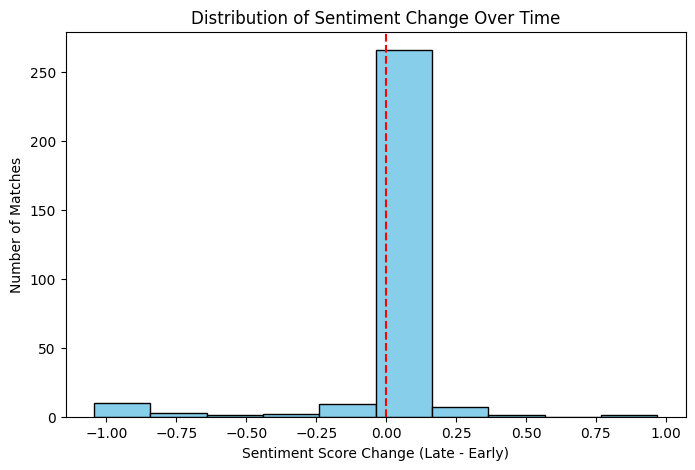

In [25]:
#  Plot sentiment scores
plt.figure(figsize=(8, 5))
plt.hist(data["sentiment_change"], bins=10, color="skyblue", edgecolor="black")
plt.axvline(0, color='red', linestyle="dashed")  # Vertical line at 0
plt.xlabel("Sentiment Score Change (Late - Early)")
plt.ylabel("Number of Matches")
plt.title("Distribution of Sentiment Change Over Time")
plt.show()


In [26]:
data.to_excel("data/feng.xlsx", index=False)